In [1]:
!ls

0218-gpt2-add-normal.ipynb     data
0218-gpt2.ipynb		       submission.csv
0219-gpt2-f1score.ipynb        submission_integers.csv
checkpoint-f1score.weights.h5  train_add_normal.csv
checkpoint.weights.h5


In [2]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
train_data_path ="~/aiffel/dktc/train_add_normal.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 4266


In [5]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['conversation'], inplace=True)
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how='any')
print('훈련 데이터의 리뷰 수 :',len(train_data))

훈련 데이터의 리뷰 수 : 4130


In [6]:
label = {'협박 대화' : '00', '갈취 대화' : '01', '직장 내 괴롭힘 대화' :'02', '기타 괴롭힘 대화' : '03', '일반 대화' : '04'}
train_data['label'] = train_data['class'].map(label)

In [7]:
train_data['class'].value_counts()

기타 괴롭힘 대화      1011
갈취 대화           973
직장 내 괴롭힘 대화     970
협박 대화           892
일반 대화           284
Name: class, dtype: int64

In [8]:
train_data['label'].value_counts()

03    1011
01     973
02     970
00     892
04     284
Name: label, dtype: int64

In [9]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
train_data['length'] = train_data['conversation'].apply(len)

In [11]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    input_ids, data_labels = [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return input_ids, data_labels

In [12]:
max_idx = train_data['length'].idxmax()
temp = tokenizer.encode(train_data['conversation'][max_idx])
max_seq_len = len(temp)
print(f'max seq len : {max_seq_len}')

train_X, train_y = convert_examples_to_features(train_data['conversation'], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

max seq len : 404


100%|██████████| 4130/4130 [00:02<00:00, 1893.43it/s]


In [14]:
model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'lm_head.weight', 'transformer.h.9.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.0.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [16]:
import tensorflow as tf
from transformers import TFGPT2Model

class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(TFGPT2ForSequenceClassification, self).__init__()
        
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        # 클래스 개수 저장
        self.num_labels = num_labels
        self.dropout = tf.keras.layers.Dropout(0.2)
        
        self.classifier = tf.keras.layers.Dense(
            # 출력 뉴런 수 = 클래스 개수
            num_labels,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
            # 다중 클래스 분류이므로 softmax 사용
            activation='softmax',
            name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        # 마지막 토큰 가져오기
        cls_token = outputs[0][:, -1]
        cls_token = self.dropout(cls_token)
        prediction = self.classifier(cls_token)

        return prediction

In [17]:
strategy = tf.distribute.MirroredStrategy() if tf.config.list_physical_devices('GPU') else tf.distribute.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = os.getenv('HOME')+'/aiffel/dktc/checkpoint-add-normal.weights.h5'

with strategy.scope():
  model = TFGPT2ForSequenceClassification(model_name="skt/kogpt2-base-v2", num_labels=5)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  # from_logits=False (Softmax 출력)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

  es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
  mc = ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_loss', save_best_only=True, verbose=1)

  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'lm_head.weight', 'transformer.h.9.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.0.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [19]:
history = model.fit(train_X, train_y, epochs=10, batch_size=8, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
413/413 [==============================] - 359s 841ms/step - loss: 1.1258 - accuracy: 0.5854 - val_loss: 2.9495 - val_accuracy: 0.5448

Epoch 00001: 

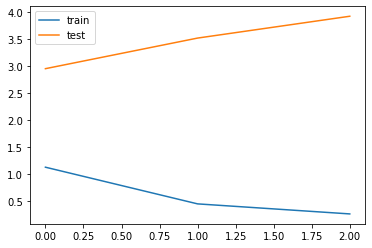

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
import pandas as pd
import json

test_json_path = os.getenv('HOME')+'/aiffel/dktc/data/test.json'

# JSON 파일 불러오기
with open(test_json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 변환: key를 인덱스로 하고, 내부 "text" 값을 컬럼으로 변환
test_data = pd.DataFrame.from_dict(data, orient="index")
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [22]:
model.load_weights(checkpoint_path)

def classify(sentence):
  bos_token = [tokenizer.bos_token]
  eos_token = [tokenizer.eos_token]

  tokens = bos_token + tokenizer.tokenize(sentence) + eos_token
  input_id = tokenizer.convert_tokens_to_ids(tokens)

  input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]
  input_id = np.array([input_id])

  scores = model.predict(input_id)[0]
  # 가장 높은 확률을 가진 클래스 선택
  predicted_class = np.argmax(scores)
  confidence = np.max(scores) * 100

  return predicted_class

In [23]:
test_data['text'][0]

'아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네'

In [24]:
classify(test_data['text'][0])

1

In [25]:
test_data['target'] = test_data['text'].apply(classify)
test_data.head()

,text,target
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,1
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,2
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,3
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,3
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,3


In [26]:
output_df = test_data[['target']].reset_index()
output_df.rename(columns={'index': 'idx'}, inplace=True)

output_df.head()

,idx,target
0,t_000,1
1,t_001,2
2,t_002,3
3,t_003,3
4,t_004,3


In [27]:
csv_path = os.getenv('HOME')+'/aiffel/dktc/submission-add-normal.csv'
output_df.to_csv(csv_path, index=False)